In [1]:
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]: make a competition submission


In [2]:
import pyarrow.parquet as pa
import pandas as pd



In [3]:
tbl = pa.read_table('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet').to_pandas()

In [4]:
# import polars as pl
# tbl = pl.read_parquet("jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet").to_pandas()

In [5]:
# schema = pa.read_schema('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
# tbllags = pa.read_table('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet', schema=schema).to_pandas()

In [6]:
#symbol : financial instrument (20 in the parquet)
# Transformer - input - seq of n instruments, window (60) * n features, to predict outcome of each instrument
# embedding of window * n features (60 * 100) to a fixed size vector (1024)

# VAR model

#### Drop columns with NA

In [7]:
# # 78 features, 8 targets
# # dropped 9 columns
# drop_threshold = 0.5
# print((tbl.isna().sum() <tbl.shape[0]*drop_threshold).sum(), tbl.shape[1])


In [8]:
tbl

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,170,0,0,2.112212,NaN,NaN,NaN,NaN,NaN,1.060330,...,-0.293646,-0.061842,-0.305413,-0.419151,-0.111796,-0.535104,-0.044332,-0.039061,-0.744789,1
1,170,0,1,2.760715,NaN,NaN,NaN,NaN,NaN,0.482468,...,-0.075267,-0.359360,-1.270054,-0.018332,-0.040286,-1.417509,0.085840,0.487232,-0.124533,1
2,170,0,2,1.813596,NaN,NaN,NaN,NaN,NaN,1.020798,...,-5.000000,-5.000000,0.194658,-5.000000,-5.000000,-5.000000,1.583400,0.018712,-1.055035,1
3,170,0,3,0.926893,NaN,NaN,NaN,NaN,NaN,0.510098,...,3.336086,2.051951,2.400644,0.962730,-0.939277,1.845870,-2.372452,-1.663179,-4.585349,1
4,170,0,7,1.665231,NaN,NaN,NaN,NaN,NaN,0.547458,...,-0.707027,-0.344866,-1.248052,-0.129645,-3.145927,-0.452708,0.300044,0.489202,0.242737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804242,339,848,19,4.384988,-0.357850,-1.135620,-0.375377,0.005456,-1.241660,-0.139730,...,0.163901,0.134067,1.124346,0.484879,0.255225,0.479602,0.008540,0.027126,0.000452,1
2804243,339,848,30,0.913199,0.013418,-1.095379,-0.315413,-0.227001,-1.131748,-0.119023,...,0.637513,-0.011480,1.779785,0.757132,0.274228,0.741818,1.014812,0.573904,2.359970,1
2804244,339,848,33,1.226038,-0.378911,-1.521467,0.209378,-0.241914,-1.597019,-0.082501,...,-3.343947,-1.012429,-2.968987,-1.112956,-0.598563,-1.537665,-0.259630,-0.105986,-0.480081,1
2804245,339,848,34,1.267464,-0.343313,-1.548126,-0.188658,0.174160,-1.160716,-0.150091,...,0.966054,0.551264,0.175104,-0.035818,-0.015150,-0.425369,-0.115926,-0.012685,-0.144224,1


In [9]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.compose import ColumnTransformer

def preprocess(df, drop_threshold=0.8):
    """
    Preprocess DataFrame:
    1) Remove columns with excessive NAs.
    2) Add lagged variables for float columns.
    3) Drop responder columns.
    4) Add time-based features.
    5) Scale numeric columns and encode categorical columns.
    6) Output a processed Pandas DataFrame.
    """
    tbl = df.copy()

    # 1. Remove columns with excessive NAs
    tbl = tbl[tbl.columns[tbl.isna().sum() < tbl.shape[0] * drop_threshold]]

    # 2. Create lagged variables for float columns
    float_cols = tbl.select_dtypes(include='float').columns
    lagged_floats = tbl[float_cols].diff().add_suffix('_l1')
    responder = tbl['responder_6']
    
    # 3. Drop responder columns
    tbl.drop(columns=['responder_0', 'responder_1', 'responder_2', 
                      'responder_3', 'responder_4', 'responder_5', 
                      'responder_6', 'responder_7', 'responder_8'], inplace=True, errors='ignore')

    # 4. Concatenate lagged variables and add time-based features
    # tbl = pd.concat([tbl, lagged_floats], axis=1).iloc[1:]  # Drop first row due to NaN from diff
    tbl[lagged_floats.columns] = lagged_floats
    tbl['day'] = tbl['date_id'] % 5
    tbl['time_var'] =  tbl['time_id'].astype(float)  / tbl['time_id'].astype(float).max()
    tbl['t'] = ((tbl['date_id'] +1).astype(int)* 1000 + tbl['time_id'].astype(int)).astype(int)
    tbl = tbl[~tbl.duplicated(subset=['symbol_id', 't'], keep=False)]
    # 5. Define column categories for scaling and encodng
    float_cols = tbl.iloc[:,3:-1].select_dtypes(include='float').columns
    int_cols = tbl.iloc[:, 3:-1].select_dtypes(exclude='float').columns #last column is time
    additional_cols = ['t', 'symbol_id']
    # 6. Set up column transformers for preprocessing
    # Float columns: impute + scale
    float_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ])
    
    # Integer columns: impute + one-hot encode
    int_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer([
        ('float_pipe', float_pipe, float_cols),
        ('int_pipe', int_pipe, int_cols)
    ], remainder='passthrough')  # Keep additional_cols as-is

    # 7. Apply transformations
    processed_data = preprocessor.fit_transform(tbl.iloc[:,3:-1])
    feature_names = (
        list(float_cols) +
        list(preprocessor.named_transformers_['int_pipe']['onehot'].get_feature_names_out(int_cols))     )

    # Convert the processed array back to a DataFrame
    processed_df = pd.DataFrame(processed_data, columns=feature_names)
    processed_df[additional_cols] = tbl[additional_cols].values

    

    # 8. Process responder column
    responder = float_pipe.fit_transform(responder.values.reshape(-1, 1))
    responder_df = pd.DataFrame({
        'symbol_id': tbl['symbol_id'].values,
        't': tbl['t'].values,
        'responder': responder.flatten()
    })


    print("Successfully created database")
    return processed_df, responder_df
X, Y = preprocess(tbl)


Successfully created database


In [10]:
# # list of
# # Step 1: Extract unique time steps
# time_steps = X['t'].unique()

# # Step 2: Create a mapping from symbol_id to indices
# symbol_ids = X['symbol_id'].unique()
# symbol_id_to_idx = {sid: idx for idx, sid in enumerate(symbol_ids)}

# # Step 3: Create a list to store (symbol_id, features) for each time step
# time_list = []

# # Step 4: Group data by time and collect (symbol_id, features) pairs
# for time in time_steps:
#     # Filter rows for the current time step
#     time_data = X[X['t'] == time]
    
#     # Create a list of (symbol_id, features) pairs
#     time_step_data = [
#         (row['symbol_id'], row.iloc[:-2].to_numpy())  # Symbol ID and features
#         for _, row in time_data.iterrows()
#     ]
    
#     # Append the list for this time step
#     time_list.append(time_step_data)

# # Step 5: Result
# print(f"Number of time steps: {len(time_list)}")
# print(f"Example for the first time step: {time_list[0]}")

In [11]:
Y

,symbol_id,t,responder
0,0,171000,0.495567
1,1,171000,0.508584
2,2,171000,0.658340
3,3,171000,0.262755
4,7,171000,0.530004
...,...,...,...
2804242,19,340848,0.500854
2804243,30,340848,0.601481
2804244,33,340848,0.474037
2804245,34,340848,0.488407


In [12]:
# time list is likely better for training

#Check what % of (symbol_id, t) pairs are missing
from itertools import product
symbol_ids = X['symbol_id'].unique()
time_steps = X['t'].unique()
complete_pairs = set(product(symbol_ids, time_steps))
actual_pairs = set(zip(X['symbol_id'], X['t']))

missing_pairs = complete_pairs - actual_pairs
fraction_missing = len(missing_pairs) / len(complete_pairs)
fraction_missing

0.028529411764705883

In [13]:
X.loc[X['t'] == 171000]


,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,...,feature_11_522,feature_11_534,partition_id_1,day_0,day_1,day_2,day_3,day_4,t,symbol_id
0,0.217512,0.563544,0.477607,0.528315,0.540944,0.498219,0.408385,0.632755,0.464445,0.581594,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,0
1,0.302123,0.563544,0.477607,0.528315,0.540944,0.498219,0.397402,0.627971,0.461222,0.592008,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,1
2,0.178550,0.563544,0.477607,0.528315,0.540944,0.498219,0.407634,0.629917,0.465252,0.591997,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,2
3,0.062860,0.563544,0.477607,0.528315,0.540944,0.498219,0.397927,0.620194,0.461707,0.598118,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,3
4,0.159193,0.563544,0.477607,0.528315,0.540944,0.498219,0.398637,0.625446,0.461352,0.595896,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,7
5,0.147093,0.563544,0.477607,0.528315,0.540944,0.498219,0.399976,0.623707,0.464232,0.593887,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,8
6,0.222624,0.563544,0.477607,0.528315,0.540944,0.498219,0.399967,0.624641,0.462551,0.594813,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,9
7,0.130841,0.563544,0.477607,0.528315,0.540944,0.498219,0.407233,0.634389,0.467274,0.593380,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,10
8,0.223452,0.563544,0.477607,0.528315,0.540944,0.498219,0.407882,0.624525,0.464138,0.593313,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,12
9,0.239690,0.563544,0.477607,0.528315,0.540944,0.498219,0.395903,0.618746,0.461229,0.600419,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,171000,13


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Custom PyTorch dataset for time series data with corresponding targets.

        Parameters:
            data (pd.DataFrame): Input data with columns ['t', 'symbol_id', ...features].
            targets (pd.DataFrame): Target data with columns ['t', 'symbol_id', 'responder'].
        """
        # Group data and targets by 't' for efficient lookup
        self.data_dict = {t: group.drop(columns=['t', 'symbol_id']).to_numpy()
                          for t, group in data.groupby('t')}
        self.symbol_dict = {t: group['symbol_id'].values for t, group in data.groupby('t')}
        self.target_dict = {t: group['responder'].values for t, group in targets.groupby('t')}

        # Store unique timesteps for __len__ and indexing
        self.time_indices = sorted(self.data_dict.keys())

    def __len__(self):
        """
        Total number of unique timesteps in the dataset.
        """
        return len(self.time_indices)

    def __getitem__(self, index):
        """
        Fetch a single timestep of data and the corresponding target for the specified symbols.

        Parameters:
            index (int): The index of the timestep to fetch.

        Returns:
            tuple:
                - torch.Tensor: A tensor of shape (n_symbols, n_features) for the input data.
                - torch.Tensor: A tensor of shape (n_symbols,) for the corresponding target.
                - np.ndarray: Array of symbols corresponding to the data.
        """
        # Fetch the timestep
        t_idx = self.time_indices[index]

        # Retrieve preprocessed data
        data_t = self.data_dict[t_idx]  # Shape: (n_symbols, n_features)
        symbols = self.symbol_dict[t_idx]  # Shape: (n_symbols,)
        target_t = self.target_dict[t_idx]  # Shape: (n_symbols,)

        # Convert to torch.Tensor
        return (
            torch.tensor(data_t, dtype=torch.float32),
            torch.tensor(target_t, dtype=torch.float32),
            symbols  # Optional: Useful for metadata/debugging
        )

cutoff = -10000

train_dataset = TimeSeriesDataset(X[:cutoff], Y[:cutoff])
val_dataset = TimeSeriesDataset(X[cutoff:], Y[cutoff:])
bs = 4096
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)


In [21]:
for x in train_loader:
    print(x[0].shape)
    break

RuntimeError: stack expects each tensor to be equal size, but got [19, 191] at entry 0 and [20, 191] at entry 2

In [ ]:
#create pos encoding based on symbol_id

In [12]:

# def to_arr(X, Y):

#     # Step 1: Extract unique symbol_ids and time_steps
#     symbol_ids = X['symbol_id'].unique()
#     time_steps = X['t'].unique()

#     # Step 2: Create mappings from symbol_id and t to indices
#     symbol_id_to_idx = {sid: idx for idx, sid in enumerate(symbol_ids)}
#     t_to_idx = {t: idx for idx, t in enumerate(time_steps)}

#     # Step 3: Vectorized mapping of symbol_id and t to indices
#     symbol_indices = X['symbol_id'].map(symbol_id_to_idx).to_numpy()
#     time_indices = X['t'].map(t_to_idx).to_numpy()

#     # Step 4: Initialize the arrays
#     n_symbols = len(symbol_ids)
#     n_times = len(time_steps)
#     n_features = len(X.columns) - 2  # Exclude symbol_id and t columns
#     X_arr = np.zeros((n_symbols, n_times, n_features))
#     Y_arr = np.zeros((n_symbols, n_times, 1))

#     # Step 5: Populate the feature array in a vectorized way
#     X_values = X.iloc[:, :-2].to_numpy()  # Extract all feature columns
#     X_arr[symbol_indices, time_indices] = X_values

#     # Step 6: Prepare the responder array (Y) in a vectorized way
#     Y_indices = Y.set_index(['symbol_id', 't'])['responder']  # Multi-index by symbol_id and t
#     Y_arr[symbol_indices, time_indices, 0] = Y_indices.loc[
#         zip(X['symbol_id'], X['t'])
#     ].to_numpy()
#     print("Array Shape:", X_arr.shape)  # (n_symbol_ids, n_time_steps, n_features)

#     return X_arr.transpose(1,0,2), Y_arr.transpose(1,0,2)
# X_arr, Y_arr = to_arr(X, Y)

Array Shape: (20, 144330, 180)


In [13]:
# np.save('data/X.npy', X_arr)
# np.save('data/Y.npy', Y_arr)

In [14]:
import numpy as np
X_arr = np.load('data/X.npy')
Y_arr = np.load('data/Y.npy')

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, window_size):
        """
        Custom PyTorch dataset for sliding window time series data with corresponding targets.

        Parameters:
            data (np.ndarray): Input data of shape (n_times, n_assets, n_features).
            targets (np.ndarray): Target data of shape (n_times, n_assets, 1).
            window_size (int): Number of timesteps in each window.
        """
        self.data = data
        self.targets = targets
        self.window_size = window_size
        self.n_times, self.n_assets, self.n_features = data.shape

        if targets.shape != (self.n_times, self.n_assets, 1):
            raise ValueError("Targets must have shape (n_times, n_assets, 1).")

    def __len__(self):
        """
        Total number of sliding windows in the dataset.
        """
        # Subtract window_size from time dimension, as we can't create windows at the very end
        return self.n_times - self.window_size + 1

    def __getitem__(self, index):
        """
        Fetch a sliding window of data and the corresponding target based on the index.

        Parameters:
            index (int): The index of the sliding window.

        Returns:
            tuple:
                - torch.Tensor: A tensor of shape (n_assets, window_size, n_features) for the input data.
                - torch.Tensor: A tensor of shape (n_assets, window_size, 1) for the corresponding target.
        """
        # Extract the sliding window
        window_data = self.data[index:index + self.window_size, :, :]

        # Transpose to match desired output shape: (n_assets, window_size, n_features)
        window_data = window_data.transpose(1, 0, 2)
        window_targets = self.targets[index + self.window_size-1, :, 0]

        # Convert to torch.Tensor
        return torch.tensor(window_data, dtype=torch.float32), torch.tensor(window_targets, dtype=torch.float32)


In [71]:
tra

NameError: name 'tra' is not defined

In [72]:
cutoff = -10000

train_dataset = TimeSeriesDataset(X_arr[:cutoff], Y_arr[:cutoff], 30)
val_dataset = TimeSeriesDataset(X_arr[cutoff:], Y_arr[cutoff:], 30)
bs = 4096
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)


In [73]:

train_dataset.targets.shape

(134330, 20, 1)

In [74]:
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([4096, 20, 30, 180]) torch.Size([4096, 20])


In [75]:
from transformer_model import Transformer

device = 'cuda'
# model = Transformer(embed_size = 16  ,  num_layers = 4, forward_expansion = 6, heads =8, dropout = 0, max_length = 60, kmer = 6, stride = 6, vocab = vocab, z=64, pe = False).to(device) #expansion 4

model = Transformer(embed_size = 64,  num_layers = 2, forward_expansion = 4, heads = 8, dropout = 0, max_length = 66, window_size = 30,n_features = 180)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define your optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_func = torch.nn.MSELoss()  # Define your loss function

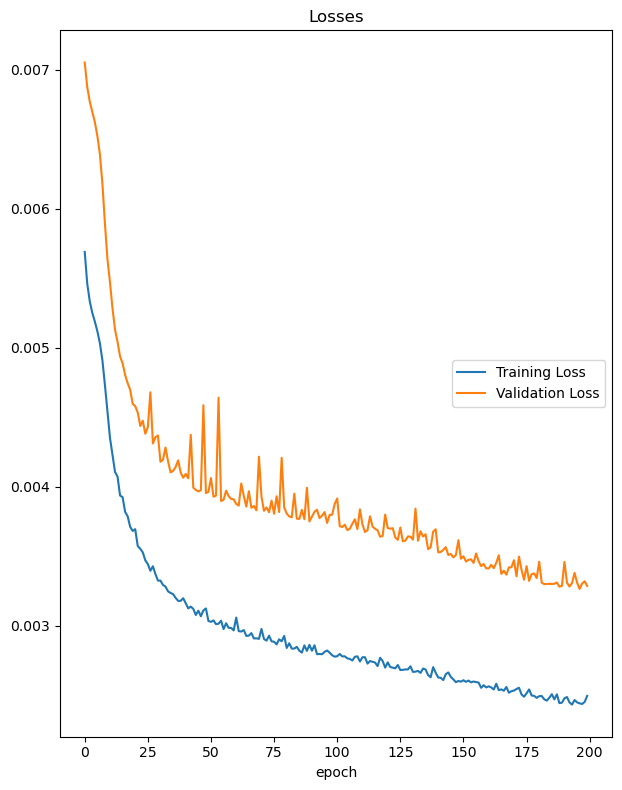

Losses
	Training Loss    	 (min:    0.002, max:    0.006, cur:    0.002)
	Validation Loss  	 (min:    0.003, max:    0.007, cur:    0.003)
Epoch 200/200, Loss: 0.0025, Time: 61.06s


In [83]:
import time
from livelossplot import PlotLosses
device = 'cuda'
model.to(device)
model.train()

# Define two groups for ladder losses and quant losses
plotlosses = PlotLosses(groups={
    'Losses': [
        'Training Loss',
        'Validation Loss'
    ]
})
best_val = 10000
epochs = 200
for epoch in range(epochs):
    start = time.time()
    total_loss1 = 0.0  # Training ladder loss
    total_loss2 = 0.0  # Training quant loss
    val_loss1 = 0.0    # Validation ladder loss
    val_loss2 = 0.0    # Validation quant loss
    num_batches = 0
    val_batches = 0
    

    # Training loop
    model.train()
    for x,y  in train_loader:
        num_batches += 1
        optimizer.zero_grad()
        x2 = model(x.to(device))
        loss = loss_func(x2.squeeze(2), y.to(device))

        
        loss.backward()
        optimizer.step()
        
        # Accumulate training losses
        total_loss1 += loss.item()


        if num_batches % 20 == 0:
            print(f'Batch: {num_batches}, MSE: {loss:.4f},')

    # Validation loop
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:
            val_batches += 1
            x2 = model(x.to(device))
            loss = loss_func(x2.squeeze(2), y.to(device))
            val_loss1 += loss.item()

    # Compute average losses
    avg_loss1 = total_loss1 / num_batches
    avg_val_loss1 = val_loss1 / val_batches
    if avg_loss1  < best_val:
        best_val = avg_loss1 
        torch.save(model.state_dict(), 'models/best.pth')
        print('Model saved')

    scheduler.step()

    # Log training and validation losses
    logs = {
        'Training Loss': avg_loss1,
        'Validation Loss': avg_val_loss1,
    }

    # Update and send the logs to livelossplot
    plotlosses.update(logs)
    plotlosses.send()

    elapsed = time.time() - start
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss1:.4f}, Time: {elapsed:.2f}s")

In [84]:
torch.save(model.state_dict(), 'models/last.pth')

#### Stationarity
Symbol 0:
almost all are nonstationary at some point in time -> we should difference all and append

In [10]:
# should add lags of time (to show gap in time)
# consider the lags issue by adding lags of responders
selected = tbl.loc[tbl['symbol_id'] == 1] #.loc[ tbl['date_id']==1]
selected_f =selected['feature_70']
selected_t = selected['t']
window = (0, 1000)

KeyError: 't'

#### ADF (Manual)

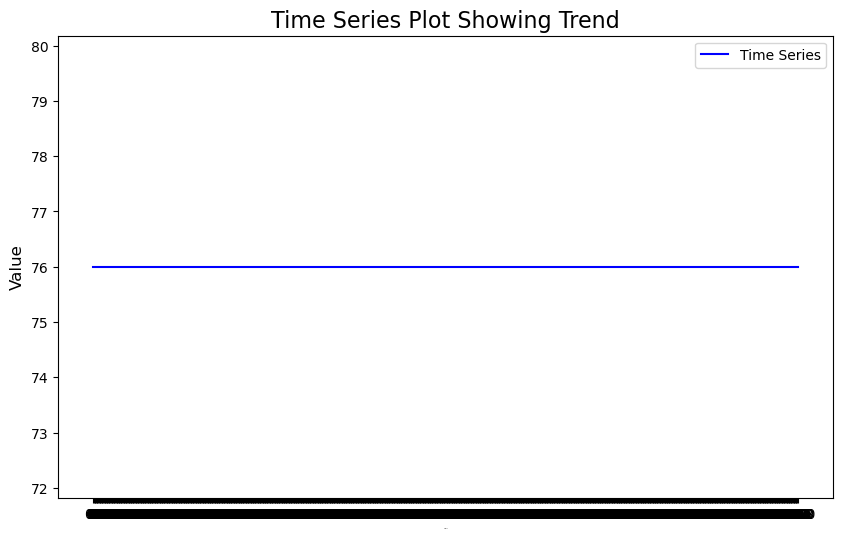

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.figure(figsize=(10, 6))
plt.plot(selected_t[window[0]:window[1]], selected_f[window[0]:window[1]], label="Time Series", color="blue")
plt.title("Time Series Plot Showing Trend", fontsize=16)
plt.xlabel("Time", fontsize=0)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

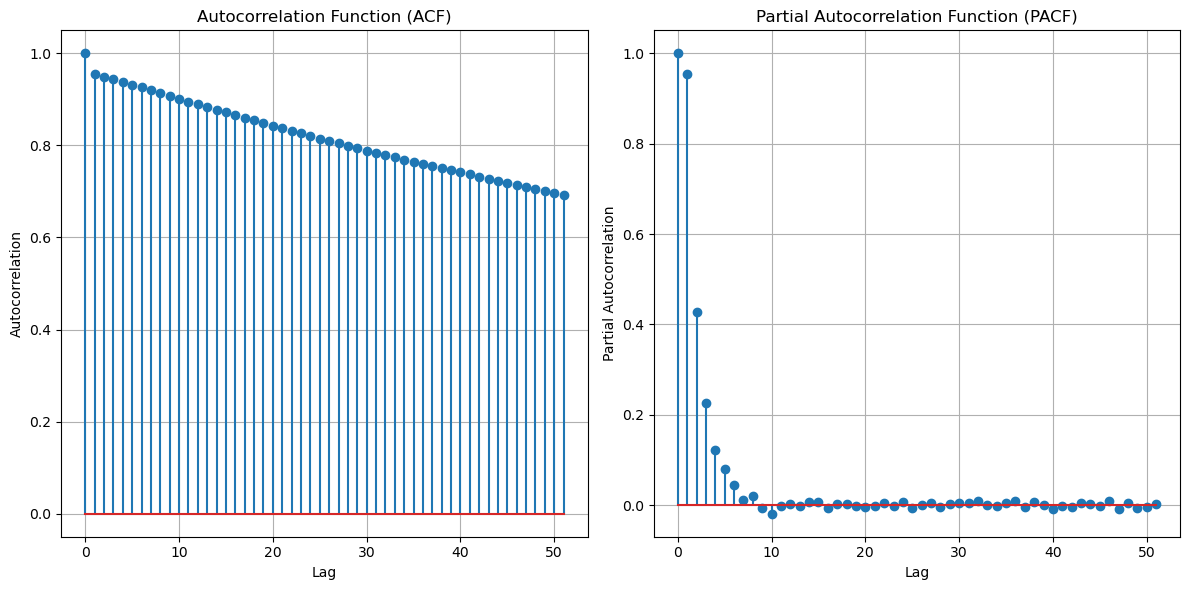

In [43]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(selected_f)
pacf_values = pacf(selected_f)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
ax[0].stem(range(len(acf_values)), acf_values)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid()

# Plot PACF
ax[1].stem(range(len(pacf_values)), pacf_values)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
def stationarity(df, threshold=0.1):
    results = {}
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include='number')
    
    for col in numeric_df.columns:
        original_var = numeric_df[col].var()
        differenced_var = numeric_df[col].diff().var()
        results[col] = (differenced_var / original_var) < threshold
    
    return results
# stationarity(selected)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [22]:
X.drop(columns = ['t'], inplace = True)

1              00
2              00
3              00
4              00
5              00
            ...  
1944205    169848
1944206    169848
1944207    169848
1944208    169848
1944209    169848
Name: t, Length: 1944209, dtype: object

In [17]:

from sklearn.model_selection import TimeSeriesSplit
import torch
import numpy as np

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# tscv = TimeSeriesSplit(n_splits=5, test_size = X.shape[0]//200)
# combine the indices for the 5 splits into one for train and val, and initialize ONE dataloader

In [ ]:
X.shape

(1944210, 84)

In [ ]:
X.shape

(1944210, 84)

In [ ]:
train_idx.shape

(1895605,)

In [ ]:
train_subset = Subset(dataset, tscv.split(X)[0][0])